## Installing dependencies

You need to install the following inorder to run this notebook.

In [30]:
# pip install pvlib
# pip install pandas
# pip install numpy
# pip install xarray
# pip install matplotlib
# pip install fastkml
# pip install shapely


## Importing and preparing the necessary packages

In [29]:

import numpy as np
import pandas as pd
import pyproj
import xarray as xr
import pvlib
import matplotlib.pyplot as plt
from fastkml import KML
from shapely.geometry import shape, box, Polygon as ShapelyPolygon
from shapely.ops import transform
from matplotlib.patches import Polygon as MatplotlibPolygon
from matplotlib.collections import PatchCollection
from pvlib import location


## Parse KML and extract rooftop geometry

In [51]:
k2 = KML.parse("../KML_file/Roof_top.kml")
features = k2.features
features2 = features[0]
features3 = features2.features
features4 = features3[0]
geometry = features4.geometry
geometry = shape(geometry)


## Defining important functions for calculating and visualizing available roof top area for PV installation

In [52]:

# Function to calculate area of the rooftop polygon
def calculate_area(polygon):
    proj = pyproj.Transformer.from_crs('EPSG:4326', 'EPSG:32637', always_xy=True)
    projected_polygon = transform(proj.transform, polygon)
    return projected_polygon.area

# Compute rooftop area
roof_area_sqm = calculate_area(geometry)
print(f"Rooftop area: {roof_area_sqm:.2f} m²")

# Function to determine number of solar panels
def calculate_number_of_panels(roof_area_sqm, panel_length_m, panel_width_m, spacing_m=0.1):
    panel_area = (panel_length_m + spacing_m) * (panel_width_m + spacing_m)  # Including spacing
    num_panels = int(roof_area_sqm // panel_area)  # Floor division
    return num_panels

# Function to apply transformation
def apply_transform(geom, transformer):
    return transform(transformer.transform, geom)

# Function to plot polygon
def plot_polygon(polygon, ax, **kwargs):
    if polygon.is_empty:
        return
    if polygon.geom_type == 'Polygon':
        # Extract only the first two dimensions (x, y) of the coordinates
        exterior_coords = np.array(polygon.exterior.coords)[:, :2]
        patch = MatplotlibPolygon(exterior_coords, **kwargs)
        ax.add_patch(patch)
    elif polygon.geom_type == 'MultiPolygon':
        for poly in polygon:
            plot_polygon(poly, ax, **kwargs)
            

Rooftop area: 209.88 m²


## Calling out the functions

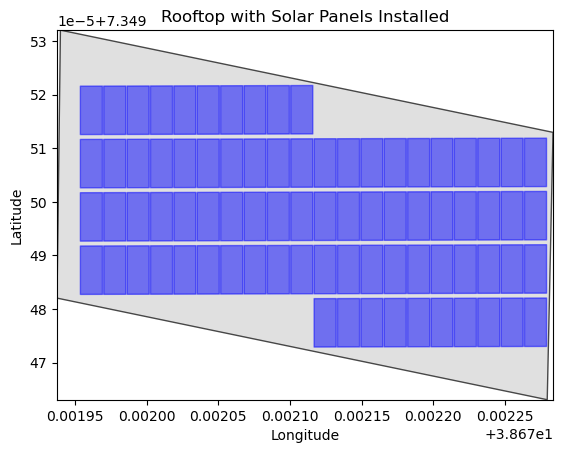

Number of installed modules: 80 modules


In [33]:
            
# Define solar panel properties
panel_length_m = 1.7  # Length of the solar panel in meters
panel_width_m = 1.0   # Width of the solar panel in meters
spacing_m = 0.1       # Spacing between panels in meters


# Define coordinate reference systems
crs_from = pyproj.CRS('EPSG:4326')  # WGS84
crs_to = pyproj.CRS('EPSG:32637')   # UTM Zone 37N
forward_transformer = pyproj.Transformer.from_crs(crs_from, crs_to, always_xy=True)
inverse_transformer = pyproj.Transformer.from_crs(crs_to, crs_from, always_xy=True)

# Project the rooftop polygon
projected_polygon = transform(forward_transformer.transform, geometry)

# Create a grid of panel placement
minx, miny, maxx, maxy = projected_polygon.bounds
x_coords = np.arange(minx, maxx, panel_length_m + spacing_m)
y_coords = np.arange(miny, maxy, panel_width_m + spacing_m)

# Plot rooftop and panel layout
fig, ax = plt.subplots()
ax.set_title('Rooftop with Solar Panels Installed')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)
plot_polygon(geometry, ax, edgecolor='black', facecolor='lightgray', alpha=0.7)
# List to store panel patches
panel_patches = []

# Counter for installed panels
installed_panels_count = 0

# Iterate over the grid and place panels
for x in x_coords:
    for y in y_coords:
        panel = box(x, y, x + panel_length_m, y + panel_width_m)
        # Check if the panel is completely within the rooftop polygon
        if projected_polygon.contains(panel):
            panel_lonlat = apply_transform(panel, inverse_transformer)
            panel_patch = MatplotlibPolygon(np.array(panel_lonlat.exterior.coords), edgecolor='blue', facecolor='blue', alpha=0.5)
            panel_patches.append(panel_patch)
            installed_panels_count += 1

# Add all panel patches to the plot
panel_collection = PatchCollection(panel_patches, match_original=True)
ax.add_collection(panel_collection)

# Set plot limits
ax.set_xlim([geometry.bounds[0], geometry.bounds[2]])
ax.set_ylim([geometry.bounds[1], geometry.bounds[3]])


# Display the plot
plt.show()

print(f"Number of installed modules: {installed_panels_count:.0f} modules")


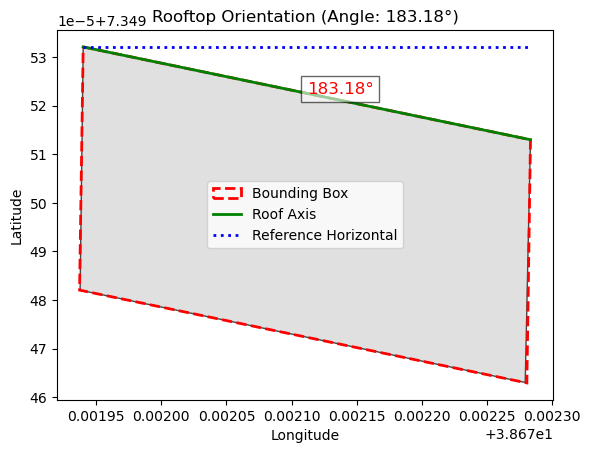

In [44]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import numpy as np

# Compute the minimum rotated rectangle
mbr = geometry.minimum_rotated_rectangle

# Extract rectangle coordinates
rect_coords = list(mbr.exterior.coords)

# Select two adjacent points to define the main axis
p1, p2 = rect_coords[:2]  # Two consecutive points defining the main axis

# Compute direction vector and angle
dx = p2[0] - p1[0]
dy = p2[1] - p1[1]
angle_counterclockwise = np.degrees(np.arctan2(dy, dx))

# Convert to clockwise angle
angle_clockwise = (360 - angle_counterclockwise) % 360

# Plot the rooftop and panels
fig, ax = plt.subplots()
ax.set_title(f'Rooftop Orientation (Angle: {angle_clockwise + 180:.2f}°)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot the original rooftop polygon
plot_polygon(geometry, ax, edgecolor='black', facecolor='lightgray', alpha=0.7)

# Plot the minimum bounding rectangle
plot_polygon(mbr, ax, edgecolor='red', facecolor='none', linestyle='dashed', linewidth=2, label="Bounding Box")

# Draw the main axis of the rooftop
ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='green', linewidth=2, label="Roof Axis")

# Draw a reference horizontal line from p1
horizontal_line = LineString([p1, (p1[0] + dx, p1[1])])
ax.plot(*horizontal_line.xy, color='blue', linestyle='dotted', linewidth=2, label="Reference Horizontal")

# Annotate the angle with a degree symbol (°)
mid_x, mid_y = (p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2
ax.text(mid_x, mid_y, f"{angle_clockwise +180 :.2f}°", fontsize=12, color="red", bbox=dict(facecolor='white', alpha=0.6))

# Show the legend
ax.legend()

# Display the plot
plt.show()


## Load and process ERA5 weather data to create location nd solar position data of the roof top


In [34]:
# Load ERA5 weather data
era5_data1 = xr.open_dataset('..\ERA5_weather_data\Era5_1.nc', engine='h5netcdf')
era5_data2 = xr.open_dataset('..\ERA5_weather_data\Era5_2.nc', engine='h5netcdf')
df1 = era5_data1[['ssrd']].to_dataframe()
df2 = era5_data2[['t2m', 'u10', 'v10']].to_dataframe()
df = pd.merge(df1.reset_index(), df2.reset_index(), on=['valid_time', 'latitude', 'longitude'])

# Rename columns to match PVLib's expected naming conventions

df.rename(columns={'ssrd': 'ghi', 't2m': 'temp_air', 'u10': 'wind_speed_u', 'v10': 'wind_speed_v'}, inplace=True)
df['wind_speed'] = (df['wind_speed_u']**2 + df['wind_speed_v']**2)**0.5
df['temp_air'] -= 273.15
df['ghi'] /= 3600
df.drop(columns=['wind_speed_u', 'wind_speed_v'], inplace=True)
df['valid_time'] = pd.to_datetime(df['valid_time'])
df = df.set_index('valid_time')

# Create location and solar position data
centroid = geometry.centroid
site = location.Location(centroid.y, centroid.x, tz='Africa/Addis_Ababa')
solpos = site.get_solarposition(df.index)
df['dni'] = pvlib.irradiance.dirint(df['ghi'], solpos['zenith'], df.index)
df['dhi'] = df['ghi'] - df['dni'] * np.cos(np.radians(solpos['zenith']))



<>:2: SyntaxWarning: invalid escape sequence '\E'
<>:3: SyntaxWarning: invalid escape sequence '\E'
<>:2: SyntaxWarning: invalid escape sequence '\E'
<>:3: SyntaxWarning: invalid escape sequence '\E'
C:\Users\kumab\AppData\Local\Temp\ipykernel_8196\979199401.py:2: SyntaxWarning: invalid escape sequence '\E'
  era5_data1 = xr.open_dataset('..\ERA5_weather_data\Era5_1.nc', engine='h5netcdf')
C:\Users\kumab\AppData\Local\Temp\ipykernel_8196\979199401.py:3: SyntaxWarning: invalid escape sequence '\E'
  era5_data2 = xr.open_dataset('..\ERA5_weather_data\Era5_2.nc', engine='h5netcdf')


## Define PV system parameters


In [46]:
# Define PV system parameters
module_power = 200
total_modules = min(installed_panels_count, 20 * (installed_panels_count // 20))
system = {'surface_tilt': 15, 'surface_azimuth': 180, 'albedo': 0.2, 'modules_per_string': 20, 'strings_per_inverter': total_modules // 20}


module_power = 200  # Nominal DC power of the module in watts 
module_parameters = {
    'pdc0': module_power,  # Nominal DC power of the module in watts
    'gamma_pdc': -0.004,  # Temperature coefficient of power in 1/°C
    'temp_ref': 25,  # Reference temperature in °C
}

# Add temperature model parameters
temperature_model_parameters = {
    'a': -3.47,  # Parameter a for the Sandia temperature model
    'b': -0.0594,  # Parameter b for the Sandia temperature model
    'deltaT': 3  # Temperature difference between cell and module back at reference conditions
}

inverter_parameters = {
    'pdc0': 25000,  # DC input power at which the inverter is rated in watts
    'eta_inv_nom': 0.90,  # Nominal inverter efficiency
    'eta_inv_ref': 0.9637  # Reference inverter efficiency
}
# Define system configuration
system = {
    'surface_tilt': 15,  # Tilt angle in degrees
    'surface_azimuth': 180,  # South-facing in Northern Hemisphere (0=North, 90=East, 180=South, 270=West)
    'albedo': 0.2,  # Ground reflection coefficient
    'modules_per_string': 20,  # Number of modules connected in series in each string
    'strings_per_inverter': 4,  # Number of parallel strings
    'racking_model': 'open_rack',  # Specify the racking model for temperature calculations
    'module_type': 'glass_polymer'  # Specify the module type for temperature calculations
}

pvsystem = pvlib.pvsystem.PVSystem(
    surface_tilt=system['surface_tilt'],
    surface_azimuth=system['surface_azimuth'],
    albedo=system['albedo'],
    module_parameters=module_parameters,
    inverter_parameters=inverter_parameters,
    modules_per_string=system['modules_per_string'],
    strings_per_inverter=system['strings_per_inverter'],
    temperature_model_parameters=temperature_model_parameters,
    racking_model=system['racking_model'],
    module_type=system['module_type']
)
mc = pvlib.modelchain.ModelChain(
    pvsystem, 
    site, 
    aoi_model='physical',
    spectral_model='no_loss',
    temperature_model='sapm',  # Use Sandia PV Array Performance Model for temperature
    losses_model='no_loss'
)


Weather data is from ERA5. The time steps are within an interval of 10 minutes. Ther dataframe contains a weather data from 2023.01.01 00:00:00 to 2023.01.08 23:00:00. 
That means there are 1152 time steps. This should be noted when calculating capacity factor and specific yield


In [47]:

weather = df[['dni', 'ghi', 'dhi', 'temp_air', 'wind_speed']].fillna(0)
mc.run_model(weather)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: pvwatts_dc
  ac_model: pvwatts_inverter
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

## Compute energy yield and capacity factor


In [48]:
total_ac_energy = mc.results.ac.sum() / 1000 / 6 # Convert 10-minute intervals to hours
capacity_factor = total_ac_energy / ((module_power * total_modules / 1000) * 192) * 100 #192 hours==6steps per hour (every 10 minutes)=1152 step in 8 days.
specific_yield = total_ac_energy / (module_power * total_modules / 1000) / 8 #8 because the calculation is based on 8 days of weather data

print(f"System capacity: {module_power * total_modules / 1000:.2f} kW DC")
print(f"Capacity factor: {capacity_factor:.2f}%")

System capacity: 16.00 kW DC
Capacity factor: 23.49%


## Financial analysis


In [49]:

cost_per_watt = 1.5  # EUR/W, adjust as needed for your location
electricity_price = 0.12  # EUR/kWh, adjust as needed for your location
system_cost = cost_per_watt * module_power * total_modules
revenue = total_ac_energy * electricity_price * 8 #8 because the calculation is based on 8 days of weather data
simple_payback = system_cost / revenue

print(f"Estimated system cost: EUR {system_cost:.2f}")
print(f"Revenue: EUR {revenue:.2f}")
print(f"Simple payback period: {simple_payback:.2f} days")


Estimated system cost: EUR 24000.00
Revenue: EUR 692.65
Simple payback period: 34.65 days


## Plot results


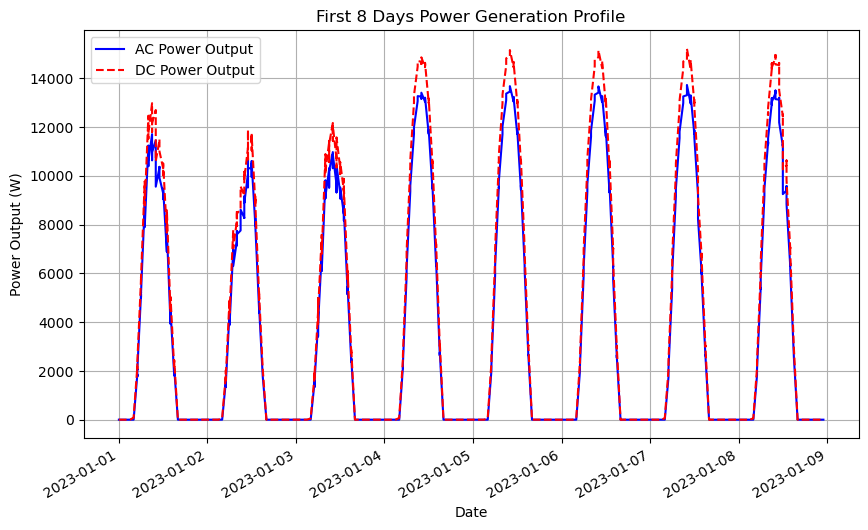

In [50]:
plt.figure(figsize=(10, 6))

# Plot AC power output
mc.results.ac.plot(label="AC Power Output", color='blue')

# Plot DC power output
mc.results.dc.plot(label="DC Power Output", color='red', linestyle='dashed')

# Add title and labels
plt.title('First 8 Days Power Generation Profile')
plt.xlabel('Date')
plt.ylabel('Power Output (W)')
plt.grid(True)

# Add a legend to distinguish between AC and DC power
plt.legend()

# Show the plot
plt.show()
